Loaded 12000 images with shape (12288,) and 3 classes.

Accuracy: 0.580
Precision: 0.582
Recall: 0.580
F1-score: 0.580
ROC AUC: 0.748

Classification Report:
               precision    recall  f1-score   support

      benign       0.54      0.57      0.56       800
  malingnant       0.62      0.54      0.58       800
      normal       0.59      0.62      0.60       800

    accuracy                           0.58      2400
   macro avg       0.58      0.58      0.58      2400
weighted avg       0.58      0.58      0.58      2400

Confusion Matrix:
 [[460 158 182]
 [196 433 171]
 [194 107 499]]


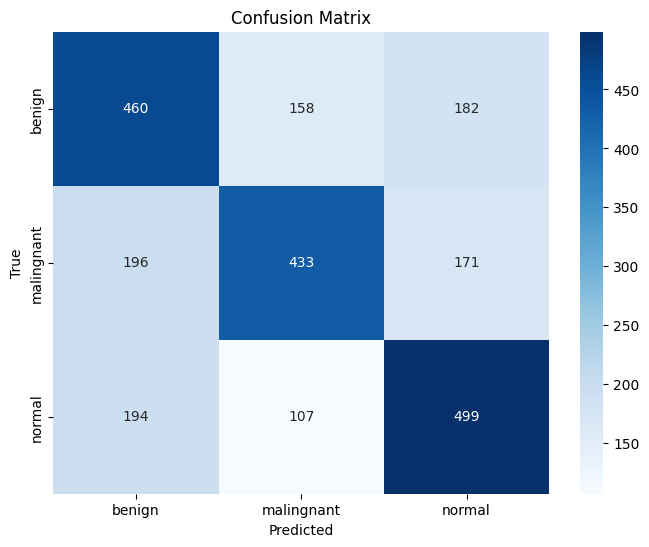

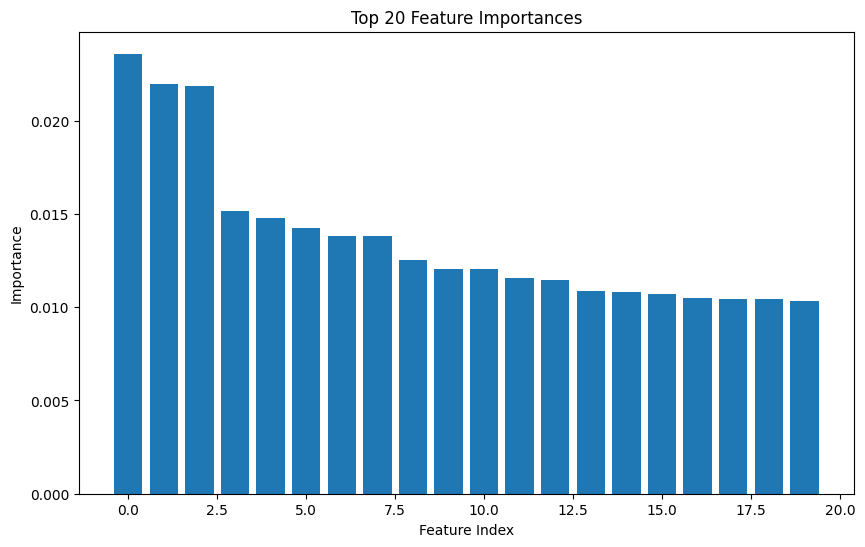

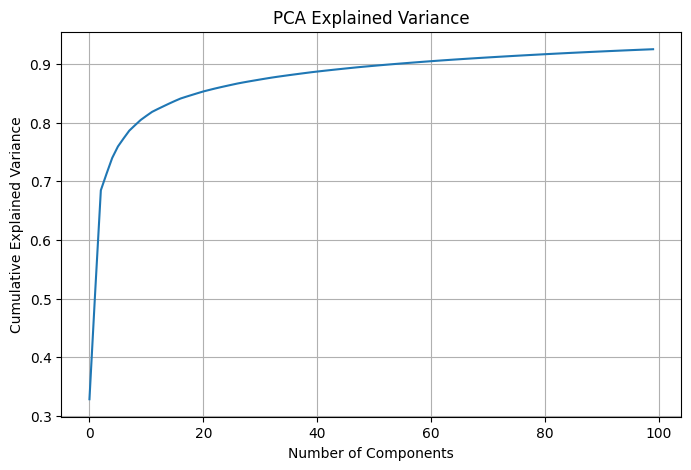

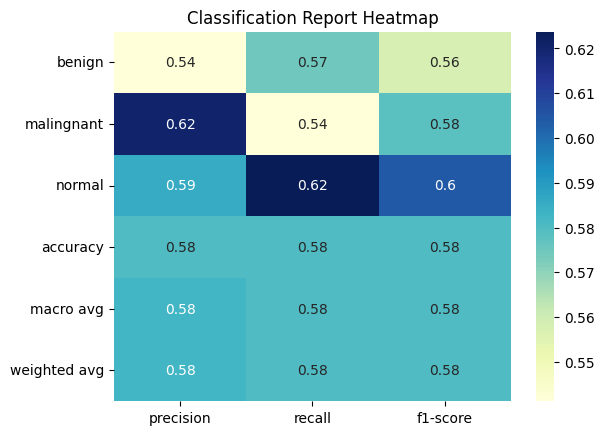

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.transform import resize

# 1. Paths
data_path = 'breast augmented images'

# 2. Load and preprocess images
img_size = (64, 64)  # smaller size for faster processing
X = []
y = []
class_names = os.listdir(data_path)
class_names = sorted([d for d in class_names if os.path.isdir(os.path.join(data_path, d))])
class_indices = {cls: i for i, cls in enumerate(class_names)}

for label in class_names:
    class_dir = os.path.join(data_path, label)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = imread(img_path)
            img_resized = resize(img, img_size, anti_aliasing=True)
            X.append(img_resized.flatten())
            y.append(class_indices[label])
        except Exception as e:
            print(f"Failed to process image {img_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} images with shape {X.shape[1:]} and {len(class_names)} classes.")

# 3. Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Optional: reduce dimensionality for performance
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# 4. Train ML classifier
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(enumerate(class_weights))
sample_weights = np.array([weight_dict[label] for label in y_train])

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_pca, y_train, sample_weight=sample_weights)

# 5. Predict
pred_labels = clf.predict(X_val_pca)
pred_probs = clf.predict_proba(X_val_pca)

# 6. Metrics
acc = accuracy_score(y_val, pred_labels)
prec = precision_score(y_val, pred_labels, average='weighted')
rec = recall_score(y_val, pred_labels, average='weighted')
f1 = f1_score(y_val, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(np.eye(len(class_names))[y_val], pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(y_val, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_val, pred_labels))

# 7. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, pred_labels), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Additional Plots
# Feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]  # Top 20 important features
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices])
plt.title("Top 20 Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# PCA explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Classification report as heatmap
report = classification_report(y_val, pred_labels, output_dict=True, target_names=class_names)
report_df = sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()


Loaded 12000 images with shape (12288,) and 3 classes.

Accuracy: 0.596
Precision: 0.599
Recall: 0.596
F1-score: 0.595
ROC AUC: 0.768

Classification Report:
               precision    recall  f1-score   support

      benign       0.59      0.52      0.55       800
  malingnant       0.65      0.59      0.62       800
      normal       0.57      0.68      0.62       800

    accuracy                           0.60      2400
   macro avg       0.60      0.60      0.60      2400
weighted avg       0.60      0.60      0.60      2400

Confusion Matrix:
 [[415 159 226]
 [136 475 189]
 [158 101 541]]


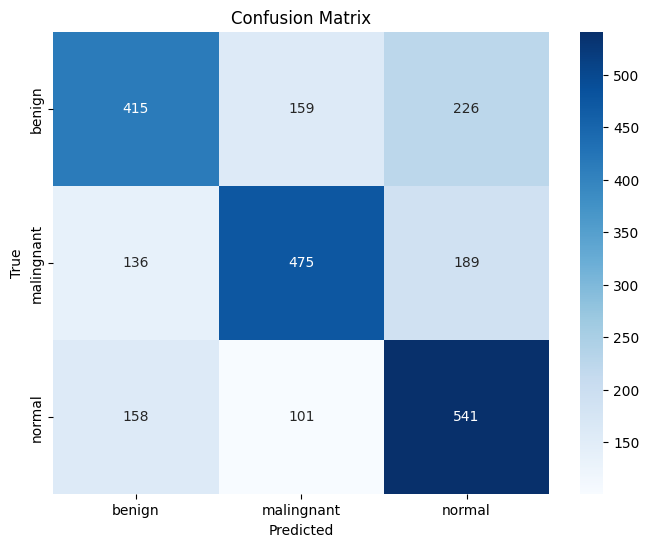

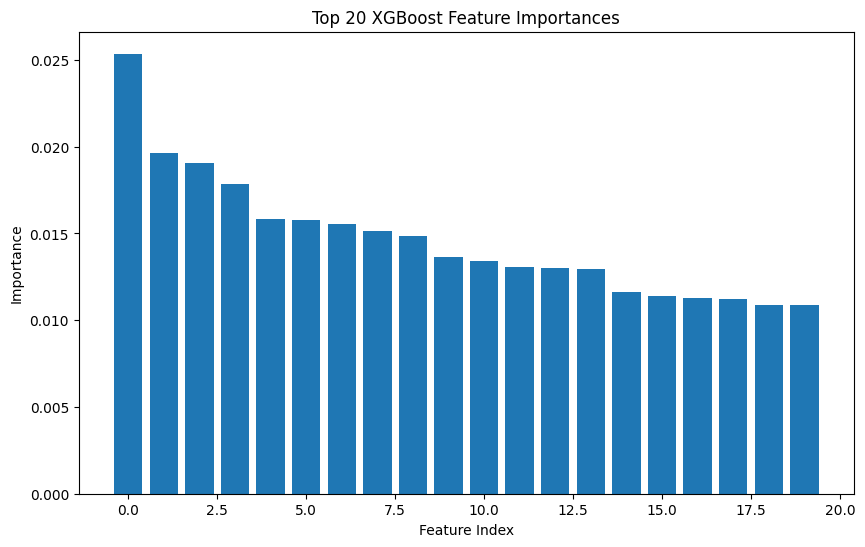

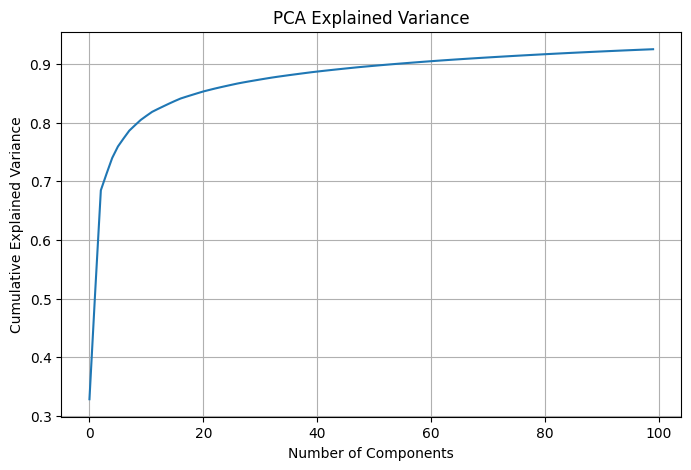

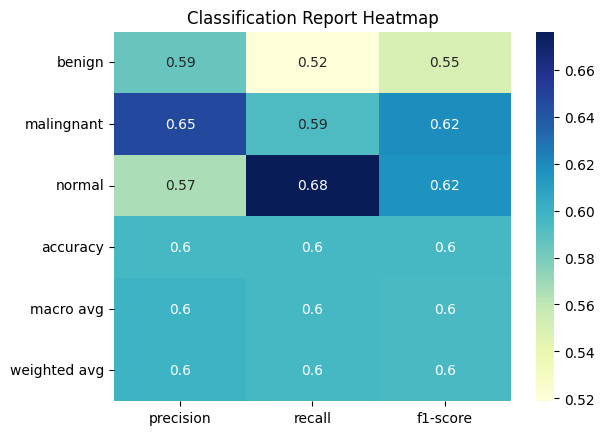

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from skimage.io import imread
from skimage.transform import resize
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# 1. Paths
data_path = 'breast augmented images'

# 2. Load and preprocess images
img_size = (64, 64)
X = []
y = []
class_names = os.listdir(data_path)
class_names = sorted([d for d in class_names if os.path.isdir(os.path.join(data_path, d))])
class_indices = {cls: i for i, cls in enumerate(class_names)}

for label in class_names:
    class_dir = os.path.join(data_path, label)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = imread(img_path)
            img_resized = resize(img, img_size, anti_aliasing=True)
            X.append(img_resized.flatten())
            y.append(class_indices[label])
        except Exception as e:
            print(f"Failed to process image {img_path}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} images with shape {X.shape[1:]} and {len(class_names)} classes.")

# 3. Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Dimensionality reduction
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# 5. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(enumerate(class_weights))

# 6. Train XGBoost model
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=1
)

# XGBoost doesn't directly accept dict for class weights, try fake or  sample  weight 
sample_weights = np.array([weight_dict[label] for label in y_train])
xgb.fit(X_train_pca, y_train, sample_weight=sample_weights)

# 7. Predict
pred_labels = xgb.predict(X_val_pca)
pred_probs = xgb.predict_proba(X_val_pca)

# 8. Metrics
acc = accuracy_score(y_val, pred_labels)
prec = precision_score(y_val, pred_labels, average='weighted')
rec = recall_score(y_val, pred_labels, average='weighted')
f1 = f1_score(y_val, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(np.eye(len(class_names))[y_val], pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(y_val, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_val, pred_labels))

# 9. Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, pred_labels), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Feature Importance
importances = xgb.feature_importances_
indices = np.argsort(importances)[-20:][::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices])
plt.title("Top 20 XGBoost Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# 11. PCA Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# 12. Classification Report as Heatmap
report = classification_report(y_val, pred_labels, output_dict=True, target_names=class_names)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()
